In [2]:
#separate data into text and labels
import pandas as pd
import numpy as np

df = pd.read_csv('text.csv')

text = []
labels = []
for row in df.iterrows():
    text.append(row[1]['text'])
    labels.append(row[1]['label'])

labels = np.array(labels)
print(labels)

[4 0 4 ... 5 3 5]


In [ ]:
#import preprocessing module(s), tokenise etc
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk import WordNetLemmatizer, pos_tag
from nltk.corpus import stopwords, wordnet
import nltk
import string
import pickle

'''tokens = []
for s in text:
    s.maketrans('','', string.punctuation)
    token = word_tokenize(s)
    for t in token:
        if t in set(stopwords.words('english')):
            token.remove(t)
    tokens.append(token)

with open('tokens', 'wb') as f:
    pickle.dump(tokens, f)

'''
with open ('tokens', 'rb') as f: #so the process need not be repeated in the future
    tokens = pickle.load(f)

print(tokens)

In [ ]:
def pos_tagger(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV

lemma = WordNetLemmatizer()
    
'''tagged = []
for sent in tokens:
    tagged.append(pos_tag(sent))
wordnet_tagged = []
for sent in tagged:
    wordnet_tagged.append(list(map(lambda x: (x[0], pos_tagger(x[1])), sent)))
print(wordnet_tagged)'''

with open('wn_tagged', 'rb') as f:
    wordnet_tagged = pickle.load(f)

In [3]:
import pickle
'''lemmatised = [] #lemmatization
for sent in wordnet_tagged:
    L = []
    for i in sent:
        if i[1] == None:
            L.append(lemma.lemmatize(i[0]))
        else:
            L.append(lemma.lemmatize(*i))
    lemmatised.append(L)'''

with open('lemmatised', 'rb') as f:
    lemmatised = pickle.load(f)


In [4]:
#split training, validation and test sentences before training **USING SMALLER DATASET AS CANNOT ALLOCATE RESOURCES**
sents_train, sents_val, sents_test = lemmatised[:round(len(lemmatised)*0.1)], lemmatised[round(len(lemmatised)*0.1):round(len(lemmatised)*0.12)], lemmatised[round(len(lemmatised)*0.12):round(len(lemmatised)*0.14)]

In [3]:
class Vectoriser():

    def __init__(self, corpus=None):
        self.word_set = {}
        if corpus:
            self.fit(corpus)
    
    def fit(self, corpus): #learns vocabulary of given corpus
        ws = self.word_set
        for d in corpus:
            for t in d:
                if t not in ws:
                    ws[t] = len(ws)
        self.word_set = ws
    
    def transform(self, doc): #returns feature vector for given document based on learned vocabulary
        vec = np.zeros([len(self.word_set)], dtype=np.short) #generates vector of zeroes the same length as learned vocabulary
        for t in doc:
            if t in self.word_set:
                vec[self.word_set[t]] += 1 #for every instance of a known word, add 1 to corresponding position in vector
        return(vec)

In [5]:
VVV = Vectoriser(sents_train) #fits vectoriser to training data

In [6]:
train_vecs = np.array([VVV.transform(x) for x in sents_train], dtype=np.byte) #small datatype so that entire array can be created
#val_vecs = np.array([VVV.transform(x) for x in sents_val], dtype=np.short)
#test_vecs = np.array([VVV.transform(x) for x in sents_test], dtype=np.short)

In [11]:
from sklearn.naive_bayes import MultinomialNB
y_train = labels[:round(len(labels)*0.1)]
'''classifier = MultinomialNB()

classifier.fit(train_vecs, y_train)


with open('trained_NB.pickle', 'rb') as f:
    classifier = pickle.load(f)'''

"classifier = MultinomialNB()\n\nclassifier.fit(train_vecs, y_train)\n\n\nwith open('trained_NB.pickle', 'rb') as f:\n    classifier = pickle.load(f)"

In [8]:
y_val = labels[round(len(labels)*0.1):round(len(labels)*0.12)]
val_vecs = np.array([VVV.transform(x) for x in sents_val], dtype=np.byte)
preds = classifier.predict(val_vecs)

total = 0
for i in range(len(preds)):
    if preds[i] == y_val[i]:
        total += 1

accuracy = total/len(preds)
print(accuracy)

0.8055422264875239


Accuracy of first Naive bayes implementation: 80.55% (2 s.f.)

In [17]:
val_pns = [[0,0,0] for i in range(6)]# 0: TP, 1: FP, 2: FN, TN can be inferred using other class TPs

for i in range(len(preds)):
    if preds[i] == y_val[i]:
        val_pns[preds[i]][0] += 1 #increase TP count on predicted/true class
    else:
        val_pns[y_val[i]][2] += 1 #increase FN count on true class
        val_pns[preds[i]][1] += 1 #increase FP count on predicted class

#Going to use micro avg first
total_tps = np.sum([x[0] for x in val_pns])
total_fps = np.sum([x[1] for x in val_pns])
total_fns = np.sum([x[2] for x in val_pns])

precision = total_tps/(total_tps+total_fps)
recall = total_tps/(total_tps+total_fns)

fscore = 2*(precision*recall)/(precision+recall) #


When using micro averaging, precision, recall and f1-score are equal to accuracy

In [5]:
emo_map = {
    0 : "Sadness",
    1 : "Joy",
    2 : "Love",
    3 : "Anger",
    4 : "Fear",
    5 : "Surprise"
}

In [21]:
from sklearn.metrics import f1_score, accuracy_score

In [18]:
mac_f1 = f1_score(y_val, preds, average='macro')
pr_re = []
for x in val_pns:
    pre = x[0]/(x[0]+x[1])
    rec = x[0]/(x[0]+x[2])
    f1 = 2*(pre*rec)/(pre+rec)
    pr_re.append([pre, rec, f1])

for i in range(len(pr_re)):
    print(str(emo_map[i])+": Precision =", str(pr_re[i][0])+", Recall =", str(pr_re[i][1])+", F1-Score =", str(pr_re[i][2]))
print(mac_f1)


Sadness: Precision = 0.7859116022099447, Recall = 0.9343185550082101, F1-Score = 0.8537134283570892
Joy: Precision = 0.7786743515850144, Recall = 0.9414634146341463, F1-Score = 0.8523659305993689
Love: Precision = 0.8589743589743589, Recall = 0.3901018922852984, F1-Score = 0.5365365365365365
Anger: Precision = 0.9004474272930649, Recall = 0.7232704402515723, F1-Score = 0.802192326856004
Fear: Precision = 0.8663911845730028, Recall = 0.6912087912087912, F1-Score = 0.7689486552567236
Surprise: Precision = 0.9210526315789473, Recall = 0.109375, F1-Score = 0.19553072625698326
0.6682146006437842


Sadness: Precision = 0.7859116022099447, Recall = 0.9343185550082101, F1-Score = 0.8537134283570892 <br>
Joy: Precision = 0.7786743515850144, Recall = 0.9414634146341463, F1-Score = 0.8523659305993689 <br>
Love: Precision = 0.8589743589743589, Recall = 0.3901018922852984, F1-Score = 0.5365365365365365 <br>
Anger: Precision = 0.9004474272930649, Recall = 0.7232704402515723, F1-Score = 0.802192326856004 <br>
Fear: Precision = 0.8663911845730028, Recall = 0.6912087912087912, F1-Score = 0.7689486552567236 <br>
Surprise: Precision = 0.9210526315789473, Recall = 0.109375, F1-Score = 0.19553072625698326 <br>
Macro averaged F1-Score = 0.6682146006437842

NOTES:  Surprise and Love missing a lot of tags, Fear and Anger missing some also <br>
        Joy being over-classified 

In [9]:
counts = [0 for i in range(6)]
for i in y_train:
    counts[i] += 1
print(counts)
print(len(y_train))

[12265, 14059, 3409, 5688, 4720, 1540]
41681


In [13]:
counts = [0 for i in range(6)]

for i in y_val:
    counts[i] += 1
print(counts)

[2436, 2870, 687, 1113, 910, 320]


In [6]:
counts = [0, 0, 0, 0, 0, 0]
sents_train_2 = []
train_labels_2 = []
for i in range(len(lemmatised)):
    if counts[labels[i]] < 7000:
        sents_train_2.append(lemmatised[i])
        train_labels_2.append(labels[i])
        counts[labels[i]] += 1

print(sents_train_2[3333])

['be', 'invite', 'dinner', 'my', 'bossman', 'friday', 'be', 'definitely', 'comfort', 'incredibly', 'invigorate', 'feel', 'be', 'some', 'pretty', 'tortured', 'experience', 'past', 'year']


In [14]:
VVV_2 = Vectoriser(sents_train_2)

train_vecs_2 = np.array([VVV.transform(x) for x in sents_train_2], np.byte)

In [15]:
classifier_2 = MultinomialNB()

classifier_2.fit(train_vecs_2, train_labels_2)

with open('trained_NB_2.pickle', 'wb') as f:
    pickle.dump(classifier_2, f)

In [19]:
preds_2 = classifier_2.predict(val_vecs)

In [ ]:
acc_2 = accuracy_score(y_val, preds_2)
print(acc_2)
fs2 = f1_score(y_val, preds_2, average='macro')
print(fs2)
val_pns_2 = [[0,0,0] for i in range(6)]# 0: TP, 1: FP, 2: FN, TN can be inferred using other class TPs

for i in range(len(preds)):
    if preds_2[i] == y_val[i]:
        val_pns_2[preds_2[i]][0] += 1 #increase TP count on predicted/true class
    else:
        val_pns_2[y_val[i]][2] += 1 #increase FN count on true class
        val_pns_2[preds_2[i]][1] += 1 #increase FP count on predicted class

pr_re_2 = []
for x in val_pns_2:
    pre = x[0]/(x[0]+x[1])
    rec = x[0]/(x[0]+x[2])
    f1 = 2*(pre*rec)/(pre+rec)
    pr_re_2.append([pre, rec, f1])

for i in range(len(pr_re_2)):
    print(str(emo_map[i])+": Precision =", str(pr_re_2[i][0])+", Recall =", str(pr_re_2[i][1])+", F1-Score =", str(pr_re_2[i][2]))

Results of Naive Bayes trained with equal numbers of each class in the training data

0.8428502879078695 <br>
0.8146509484657026<br>
Sadness: Precision = 0.9391143911439115, Recall = 0.8357963875205254, F1-Score = 0.8844483058210252<br>
Joy: Precision = 0.9633187772925764, Recall = 0.7686411149825784, F1-Score = 0.8550387596899225<br>
Love: Precision = 0.6150190114068441, Recall = 0.9417758369723436, F1-Score = 0.7441058079355951<br>
Anger: Precision = 0.8202068416865553, Recall = 0.9263252470799641, F1-Score = 0.870042194092827<br>
Fear: Precision = 0.790258449304175, Recall = 0.8736263736263736, F1-Score = 0.8298538622129437<br>
Surprise: Precision = 0.5523978685612788, Recall = 0.971875, F1-Score = 0.7044167610419025<br>

TF-IDF START

TF = Number of occurrences in document/total words in document

IDF = log(total docs/docs with term)

tf-idf = tf*idf

In [18]:
class TFIDF_calc():

    def __init__(self, corpus):
        self.wordset = {}
        self.total_docs = len(corpus)
        self.fit(corpus)
    
    def fit(self, corpus):
        ws = self.wordset
        for d in corpus:
            dws = set()         #create set to hold unique words present in document
            for t in d:
                if t not in dws:
                    dws.add(t)
            for w in dws:
                if w not in ws:
                    ws[w] = [len(ws), 1] #if word unseen, add to corpus word set
                else:
                    ws[w][1] += 1 #if word already seen, increase num of documents it has been seen in by 1
        for w in ws:
            ws[w][1] = np.log(len(corpus)/ws[w][1]) #convert doc frequency to idf values
        self.wordset = ws
    
    def transform(self, doc):
        vec = np.zeros((len(self.wordset)), dtype='float')
        dws = {}
        for w in doc:
            if w in dws:
                dws[w] += 1
            else:
                dws[w] = 1
        for w in dws:
            tf = dws[w]/len(doc)
            if w in self.wordset:
                vec[self.wordset[w][0]] = tf*self.wordset[w][1] 
        return vec


In [19]:
TV = TFIDF_calc(sents_train_2)

train_vecs_3 = np.array([TV.transform(d) for d in sents_train_2])
val_vecs_3 = np.array([TV.transform(d) for d in sents_val])
y_val = labels[round(len(labels)*0.1):round(len(labels)*0.12)]

In [20]:
classifier_3 = MultinomialNB()

classifier_3.fit(train_vecs_3, train_labels_2)

with open('trained_tfidf_NB.pickle', 'wb') as f:
    pickle.dump(classifier_3, f)

In [ ]:
preds_3 = classifier_3.predict(val_vecs_3)

acc_3 = accuracy_score(y_val, preds_3)
f1_3 = f1_score(y_val, preds_3, average='macro')
print(acc_3, f1_3)

val_pns_3 = [[0,0,0] for i in range(6)]# 0: TP, 1: FP, 2: FN, TN can be inferred using other class TPs

for i in range(len(preds_3)):
    if preds_3[i] == y_val[i]:
        val_pns_3[preds_3[i]][0] += 1 #increase TP count on predicted/true class
    else:
        val_pns_3[y_val[i]][2] += 1 #increase FN count on true class
        val_pns_3[preds_3[i]][1] += 1 #increase FP count on predicted class

pr_re_3 = []
for x in val_pns_3:
    pre = x[0]/(x[0]+x[1])
    rec = x[0]/(x[0]+x[2])
    f1 = 2*(pre*rec)/(pre+rec)
    pr_re_3.append([pre, rec, f1])

for i in range(len(pr_re_3)):
    print(str(emo_map[i])+": Precision =", str(pr_re_3[i][0])+", Recall =", str(pr_re_3[i][1])+", F1-Score =", str(pr_re_3[i][2]))

0.8495681381957774 0.8203670330670617<br>
Sadness: Precision = 0.9418550992155053, Recall = 0.8378489326765188, F1-Score = 0.8868129480773408<br>
Joy: Precision = 0.9528619528619529, Recall = 0.7888501742160279, F1-Score = 0.8631338162409454<br>
Love: Precision = 0.631786771964462, Recall = 0.9315866084425036, F1-Score = 0.7529411764705882<br>
Anger: Precision = 0.8469135802469135, Recall = 0.9245283018867925, F1-Score = 0.8840206185567011<br>
Fear: Precision = 0.7897838899803536, Recall = 0.8835164835164835, F1-Score = 0.8340248962655602<br>
Surprise: Precision = 0.5557586837294333, Recall = 0.95, F1-Score = 0.7012687427912341 <br>

NOTES: TF-IDF vectors slightly increased Accuracy and F1-Score, Main issue is again love and surprise, but now they are being overclassified. Maybe use training dataset with the log of the true proportions.

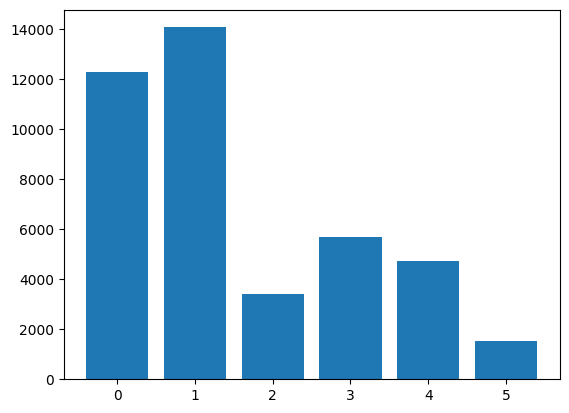

In [27]:
import matplotlib.pyplot as plt

true = [0 for i in range (6)]
for i in y_train:
    true[i] += 1

plt.bar([i for i in range(6)], true)
plt.show()


Ratio in simplest form: 12265 : 14059 : 3409 : 5688 : 4720 : 1540 <br>
Log of ratio: 9415 : 9551 : 8134 : 8646 : 8460 : 7340

In [56]:
log_ratio = [9415, 9551, 8134, 8646, 8460, 7340] #getting training dataset with the proportion of each classes equal to the log of the true proportions

log_ratio = [np.round(i*0.8) for i in log_ratio]

counts = [0, 0, 0, 0, 0, 0] #
sents_train_4 = []
train_labels_4 = []

for i in range(len(lemmatised)):
    if counts[labels[i]] < log_ratio[labels[i]]:
        sents_train_4.append(lemmatised[i])
        train_labels_4.append(labels[i])
        counts[labels[i]] += 1

In [62]:
print(np.sum(true))

41681


In [58]:
tfidf_2 = TFIDF_calc(sents_train_4)

train_vecs_4 = np.array([tfidf_2.transform(x) for x in sents_train_4])

classifier_4 = MultinomialNB()
classifier_4.fit(train_vecs_4, np.array(train_labels_4))

with open('tfidf_2.pickle', 'wb') as f:
    pickle.dump(classifier_4, f)

In [60]:
val_vecs_4 = np.array([tfidf_2.transform(x) for x in sents_val])
preds_4 = classifier_4.predict(val_vecs_4)

In [61]:
acc_4 = accuracy_score(y_val, preds_4)
f1_4 = f1_score(y_val, preds_4, average='macro')
print(acc_4, f1_4)

val_pns_4 = [[0,0,0] for i in range(6)]# 0: TP, 1: FP, 2: FN, TN can be inferred using other class TPs

for i in range(len(preds_4)):
    if preds_4[i] == y_val[i]:
        val_pns_4[preds_4[i]][0] += 1 #increase TP count on predicted/true class
    else:
        val_pns_4[y_val[i]][2] += 1 #increase FN count on true class
        val_pns_4[preds_4[i]][1] += 1 #increase FP count on predicted class

pr_re_4 = []
for x in val_pns_4:
    pre = x[0]/(x[0]+x[1])
    rec = x[0]/(x[0]+x[2])
    f1 = 2*(pre*rec)/(pre+rec)
    pr_re_4.append([pre, rec, f1])

for i in range(len(pr_re_4)):
    print(str(emo_map[i])+": Precision =", str(pr_re_4[i][0])+", Recall =", str(pr_re_4[i][1])+", F1-Score =", str(pr_re_4[i][2]))

0.8738003838771593 0.8521126060748608
Sadness: Precision = 0.9250757903854483, Recall = 0.8768472906403941, F1-Score = 0.9003161222339305
Joy: Precision = 0.933718689788054, Recall = 0.8442508710801394, F1-Score = 0.8867337602927722
Love: Precision = 0.6908267270668177, Recall = 0.8879184861717613, F1-Score = 0.7770700636942676
Anger: Precision = 0.8666666666666667, Recall = 0.9227313566936208, F1-Score = 0.8938207136640557
Fear: Precision = 0.8216106014271152, Recall = 0.8857142857142857, F1-Score = 0.8524590163934426
Surprise: Precision = 0.7362924281984334, Recall = 0.88125, F1-Score = 0.8022759601706971


0.8738003838771593 0.8521126060748608 <br>
Sadness: Precision = 0.9250757903854483, Recall = 0.8768472906403941, F1-Score = 0.9003161222339305<br>
Joy: Precision = 0.933718689788054, Recall = 0.8442508710801394, F1-Score = 0.8867337602927722<br>
Love: Precision = 0.6908267270668177, Recall = 0.8879184861717613, F1-Score = 0.7770700636942676<br>
Anger: Precision = 0.8666666666666667, Recall = 0.9227313566936208, F1-Score = 0.8938207136640557<br>
Fear: Precision = 0.8216106014271152, Recall = 0.8857142857142857, F1-Score = 0.8524590163934426<br>
Surprise: Precision = 0.7362924281984334, Recall = 0.88125, F1-Score = 0.8022759601706971<br>
NOTES: Using the log of the true ratios seems to provide a good optimum ratio (there are still roughly the same number of total data points in the training set). Accuracy increased by a further 2% while f1-score increased by about 3%